In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
#import cianparser # https://github.com/lenarsaitov/cianparser
import distance
import copy
from jellyfish import jaro_winkler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingRegressor, \
    AdaBoostClassifier,AdaBoostRegressor,GradientBoostingClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split,HalvingGridSearchCV,cross_val_score
from sklearn.preprocessing import LabelEncoder,PolynomialFeatures,StandardScaler,RobustScaler
from sklearn.linear_model import SGDRegressor,LinearRegression,Lasso
from imblearn.ensemble import EasyEnsembleClassifier,BalancedRandomForestClassifier
from imblearn.over_sampling import RandomOverSampler,SMOTE
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,f1_score, \
    r2_score, mean_absolute_error, mean_squared_error, classification_report,median_absolute_error
from scipy.stats import pearsonr
import statsmodels.api as sm
# from keras.models import Sequential
# from keras.layers import Dense
import joblib

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [15]:
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQxxmZm6YG54VucQ9yRgWFQXtOI-RFJ5-sOLT93LpaYGYc-vabL9LOzzkRXX-LmSROTA7hOL1C327nZ/pub?gid=213261502&single=true&output=csv')

# Первоначальная предобработка данных(квартиры на продажу в Москве и Санкт-Петербурге)

In [16]:
data.head()

,author,author_type,link,city,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,phone,district,street,underground,residential_complex
0,Петербургская Строительная Компания,developer,https://spb.cian.ru/sale/flat/284740225/,Sankt-Peterburg,sale,flat,1,7,1.0,38.20,419999,16044000,2023,12.0,12.0,7.812218e+10,Petrogradskij,Chkalovskoe,Petrogradskaja,Severnaja Korona
1,Петербургская Строительная Компания,developer,https://spb.cian.ru/sale/flat/280819981/,Sankt-Peterburg,sale,flat,13,25,1.0,36.81,33201,6706674,2024,10.0,13.0,7.812218e+10,Primorskij,Kolomjagi,Prospekt Prosveschenija,Frends ZhK
2,GloraX,developer,https://spb.cian.ru/sale/flat/279507591/,Sankt-Peterburg,sale,flat,5,19,1.0,36.76,265777,9769999,2025,11.0,11.0,7.812213e+10,Vasileostrovskij,Morskoj,Zenit,Gloraks Premium Vasileostrovskij ZhK
3,Группа Эталон,developer,https://spb.cian.ru/sale/flat/285017335/,Sankt-Peterburg,sale,flat,13,18,1.0,32.60,303116,9881582,2022,21.0,-1.0,7.812213e+10,Admiraltejskij,Izmajlovskoe,Moskovskie vorota,Kvartal Galaktika
4,GloraX,developer,https://spb.cian.ru/sale/flat/279351916/,Sankt-Peterburg,sale,flat,11,14,1.0,34.44,322009,11089999,2024,12.0,13.0,7.812213e+10,Krasnogvardejskij,Malaja Ohta,Ladozhskaja,Glorax Zanevskij


In [5]:
data.shape

(15495, 20)

In [18]:
data['flat_id'] = data['link'].str.extract('(\d+)')

In [19]:
data.drop('link', axis = 1,inplace = True)

In [20]:
data.drop(['accommodation_type','deal_type'],axis = 1,inplace = True)

In [9]:
data.drop('phone', axis =1, inplace=True)

In [21]:
data_duplicated_indexes = data[data.duplicated() == True].index

In [22]:
data.isna().sum()

author                    91
author_type               80
city                       0
floor                      0
floors_count               0
rooms_count                0
total_meters               0
price_per_m2               0
price                      0
year_of_construction       0
living_meters              0
kitchen_meters             0
phone                      1
district                 764
street                  1528
underground              643
residential_complex     5902
flat_id                    0
dtype: int64

In [23]:
data = data.drop(data_duplicated_indexes, axis =0)

In [25]:
data[['total_meters', 
      'price_per_m2',
      'year_of_construction',
      'living_meters',
      'kitchen_meters']] = data[['total_meters', 'price_per_m2','year_of_construction','living_meters','kitchen_meters']].replace(-1.0, None)

In [26]:
data[['total_meters', 
      'price_per_m2',
      'year_of_construction',
      'living_meters',
      'kitchen_meters']].dtypes

total_meters            object
price_per_m2             int64
year_of_construction    object
living_meters           object
kitchen_meters          object
dtype: object

In [27]:
data.isna().sum()

author                    91
author_type               80
city                       0
floor                      0
floors_count               0
rooms_count                0
total_meters               9
price_per_m2               0
price                      0
year_of_construction     719
living_meters           3278
kitchen_meters          3508
phone                      1
district                 764
street                  1527
underground              643
residential_complex     5898
flat_id                    0
dtype: int64

In [ ]:
data.drop(data[(data.isna().sum(axis=1) >= 4)].index, axis = 0, inplace =True)

In [ ]:
data.loc[(data.price_per_m2 <=0),'price_per_m2'] = None 

In [28]:
data.isna().sum()

author                    91
author_type               80
city                       0
floor                      0
floors_count               0
rooms_count                0
total_meters               9
price_per_m2               0
price                      0
year_of_construction     719
living_meters           3278
kitchen_meters          3508
phone                      1
district                 764
street                  1527
underground              643
residential_complex     5898
flat_id                    0
dtype: int64

In [ ]:
data['author'].fillna(data['author'].mode()[0], inplace =True)
data['author_type'].fillna(data['author_type'].mode()[0], inplace =True)

In [ ]:
data[['total_meters',
             'living_meters',
             'kitchen_meters']] = data[['total_meters','living_meters','kitchen_meters']].astype('float64')

In [ ]:
data['total_meters'].fillna(data['total_meters'].median(), inplace =True)
data['price_per_m2'].fillna(data['price_per_m2'].median(), inplace =True)

In [ ]:
data['year_of_construction'] = data['year_of_construction'].astype('int64',errors='ignore')

In [ ]:
data.isna().sum()

In [ ]:
data = data.drop(data[data['year_of_construction'].isna()].index, axis = 0)

In [ ]:
data = data.drop(data[data['living_meters'] < 0].index, axis = 0)

# EDA

In [ ]:
data.isna().sum()

In [ ]:
data.describe(include=['int64','float64'])

In [ ]:
data.describe(include=['O'])

In [ ]:
plt.figure(figsize=(7,5))
plt.boxplot([data['total_meters'],
             data[data['living_meters'].notnull()]['living_meters'],
             data[data['kitchen_meters'].notnull()]['kitchen_meters']])
plt.xticks([1,2,3],['total_meters','living_meters','kitchen_meters']);

In [ ]:
district_top30 = data.district.value_counts()
plt.figure(figsize=(7,5))
sns.barplot(x = district_top30.index[:30], y =district_top30[:30])
plt.ylabel('Количество квартир на продажу в этом районе')
plt.xlabel('Район')
plt.xticks(rotation = 45,ha='right');

In [ ]:
developers_top10 = data['author'].value_counts()[:10]
plt.figure(figsize=(5,4))
sns.barplot(x = developers_top10.index, y =developers_top10)
plt.ylabel('Количество предложений на рынке')
plt.xlabel('Застройщик')
plt.xticks(rotation = 30,ha='right');

In [ ]:
sns.jointplot(x = data.living_meters,y = data['total_meters'], kind = 'reg');

In [ ]:
corr_matrix = data.corr(numeric_only =True)
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.35] = 0
plt.figure(figsize=(7,7))
sns.heatmap(corr_matrix,annot=True,linewidths = 0.5, cmap = 'coolwarm');

## living_meters (исследование признака и заполнение пропусков)

In [ ]:
plt.figure(figsize = (7,7))
sns.pairplot(data[['living_meters','total_meters','price','kitchen_meters']],
             height=2.5, aspect=1.5, 
             diag_kind='hist');

In [ ]:
plt.figure(figsize = (5,5))
sns.histplot(data=data['living_meters'],bins =30);

In [ ]:
# создаю датасет для регрессии
data_reg = data[['living_meters','total_meters','price','kitchen_meters','rooms_count']].copy()

In [ ]:
corr_matrix = data_reg.corr()
sns.heatmap(corr_matrix, annot =True);

In [ ]:
# проверяю линейную связь между целевой и независимыми переменными
living_meters_nonan = data_reg[(data_reg['living_meters'].notnull()) & (data_reg['kitchen_meters'].notnull())]['living_meters']

pvalue1 = pearsonr(living_meters_nonan.values,data_reg.loc[living_meters_nonan.index,'total_meters'].values)[1]

pvalue2 = pearsonr(living_meters_nonan.values,data_reg.loc[living_meters_nonan.index,'kitchen_meters'].values)[1]

pvalue3 = pearsonr(living_meters_nonan.values,data_reg.loc[living_meters_nonan.index,'price'].values)[1]

pvalue4 = pearsonr(living_meters_nonan.values,data_reg.loc[living_meters_nonan.index,'rooms_count'].values)[1]
print(pvalue1,pvalue2,pvalue3)

In [ ]:
# проверка мультиколлинеарности
pear1 = pearsonr(data_reg.loc[living_meters_nonan.index,'total_meters'].values,
                   data_reg.loc[living_meters_nonan.index,'kitchen_meters'].values)

pear2 = pearsonr(data_reg.loc[living_meters_nonan.index,'total_meters'].values,
                   data_reg.loc[living_meters_nonan.index,'price'].values)

pear3 = pearsonr(data_reg.loc[living_meters_nonan.index,'kitchen_meters'].values,
                   data_reg.loc[living_meters_nonan.index,'price'].values)
pear4 = pearsonr(data_reg.loc[living_meters_nonan.index,'rooms_count'].values,
                   data_reg.loc[living_meters_nonan.index,'total_meters'].values)
print(pear1,pear2,pear3,pear4)

## Условия для линейной регрессии
1. Количественные переменные
2. линейная связь между зависимой и независимыми переменными(есть)
3. нормальное распределение ошибок
4. Гомоскедастичность(остатки имеют плюс-минус равную дисперсию во всех значениях х)
5. Отсутствует мультиколлинеарность(независимые переменные:,'total_meters','kitchen_meters','price'), почти отсутсвует

## LinearRegression

In [ ]:
lr = LinearRegression(fit_intercept=True)
y_living_meters = data_reg[(data_reg['living_meters'].notnull()) & (data_reg['kitchen_meters'].notnull())]['living_meters']
X_living_meters = data_reg[(data_reg['living_meters'].notnull()) & (data_reg['kitchen_meters'].notnull())].iloc[:,[1,2,3,4]]
lr.fit(X_living_meters,y_living_meters)
y_pred = lr.predict(X_living_meters)
resid = y_living_meters - y_pred

In [ ]:
lr.intercept_

In [ ]:
# тест на автокорреляцию остатков
sm.stats.stattools.durbin_watson(resid)

Автокорреляция остатков почти отсутствует, так как тест показал 1.69(2 это полное отсутствие)

In [ ]:
# распределение ошибок
plt.figure(figsize= (3,3))
plt.hist(resid,bins = 30);

In [ ]:
# гомоскедастичность остатков
for i in range(0,4):
    plt.figure(figsize= (3,3))
    plt.scatter(X_living_meters.iloc[:,i].values, resid.values, alpha=0.5)
    plt.axhline(y=0, color='g', linestyle='-')
    plt.xlabel(f'{X_living_meters.columns[i]}')
    plt.ylabel('Остатки')
    plt.title(f'График остатков для {X_living_meters.columns[i]}')
plt.show()

In [ ]:
mae = mean_absolute_error(y_living_meters.values, y_pred) 
# mae насколько в среднем по модулю отличаются предсказанные от истинных в оригинальных единицах измерения
mse = mean_squared_error(y_living_meters.values, y_pred) # mse и rmse сильнее подвержены влиянию выбросов, чем mae
rmse = np.sqrt(mse)
r2 = r2_score(y_living_meters.values, y_pred)
print('mae: %.3f \nmse: %.3f \nrmse: %.3f \nr2:%.3f'%(mae,mse,rmse,r2))

In [ ]:
lr.score(X_living_meters, y_living_meters)

In [ ]:
SSR = np.sum(resid**2)
# Стандартная ошибка оценки (Standard Error of the Estimate, SEE)
SSE = np.sqrt(SSR / (len(y_living_meters) - X_living_meters.shape[1]+1))
# SSR - сумма квадратов остатков, n - количество наблюдений и p - количество параметров (коэффициентов), включая константу.
print(f'SSE:{SSE}')

In [ ]:
scores = cross_val_score(lr, X_living_meters, y_living_meters, cv=5)
print('CV R^2: {:.3f} +- {:.3f}'.format(np.mean(scores), np.std(scores)))

In [ ]:
plt.figure(figsize=(5, 5))
sns.histplot(y_pred)
sns.histplot(y_living_meters);

## Полиномиальная регрессия - оказалась лучше множественной линейной регрессии(лучший набор признаков : 1,3,4)

In [ ]:
y_living_meters = data_reg[(data_reg['living_meters'].notnull())]['living_meters']
X_living_meters = data_reg[(data_reg['living_meters'].notnull())].iloc[:,[1,2,4]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_living_meters, y_living_meters, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=1)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)
lr = LinearRegression(fit_intercept=True)

lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
resid = y_test - y_pred

mae = mean_absolute_error(y_test, y_pred) 
# rmse насколько в среднем по модулю отличаются предсказанные от истинных в оригинальных единицах измерения
mse = mean_squared_error(y_test, y_pred) # mse и rmse сильнее подвержены влиянию выбросов, чем mae
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print('mae: %.3f \nmse: %.3f \nrmse: %.3f \nr2:%.3f'%(mae,mse,rmse,r2))

In [ ]:
plt.figure(figsize=(5, 5))
sns.histplot(y_pred,bins = 75)
sns.histplot(y_test,bins = 75);

In [ ]:
sm.stats.stattools.durbin_watson(resid)

In [ ]:
# распределение ошибок
plt.figure(figsize= (3,3))
plt.hist(resid,bins = 30);

In [ ]:
scores = cross_val_score(lr, X_test, y_test, cv=5)
print('CV R^2: {:.3f} +- {:.3f}'.format(np.mean(scores), np.std(scores)))

In [ ]:
living_meters_nan = data[data.living_meters.isna()][['total_meters','price','rooms_count']]
living_meters_nan = poly.fit_transform(living_meters_nan)
living_meters_nan = lr.predict(living_meters_nan)

In [ ]:
plt.figure(figsize=(5, 5))
sns.histplot(living_meters_nan,bins = 75);

In [ ]:
data.loc[data.living_meters.isna(),'living_meters'] = living_meters_nan

## Заполнение пропусков в kitchen_meters
(заметка:с категориальными признаками нет корреляции вообще)

## LinearRegression

In [ ]:
data['year_of_construction'] = data.year_of_construction.astype('int32')

In [ ]:
lr = LinearRegression(fit_intercept=True)
y = data[(data['kitchen_meters'].notnull())]['kitchen_meters'].copy()
X = data.select_dtypes(['float','int'])[(data['kitchen_meters'].notnull())].iloc[:,[2,3,5,7]].copy()

In [ ]:
lr.fit(X,y)
y_pred = lr.predict(X)
resid = y - y_pred

In [ ]:
mae = mean_absolute_error(y.values, y_pred) 
mse = mean_squared_error(y.values, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y.values, y_pred)
print('mae: %.3f \nmse: %.3f \nrmse: %.3f \nr2:%.3f'%(mae,mse,rmse,r2))

## Полином

In [ ]:
y = data[(data['kitchen_meters'].notnull())]['kitchen_meters'].copy()
X = data.select_dtypes(['float','int'])[(data['kitchen_meters'].notnull())].iloc[:,[2,3,5,7]].copy()

poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(X)
lr = LinearRegression(fit_intercept=True)

lr.fit(X,y)
y_pred = lr.predict(X)
resid = y - y_pred

In [ ]:
mae = mean_absolute_error(y.values, y_pred) 
mse = mean_squared_error(y.values, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y.values, y_pred)
print('mae: %.3f \nmse: %.3f \nrmse: %.3f \nr2:%.3f'%(mae,mse,rmse,r2))

## Градиентный бустинг

Подобрал оптимальные параметры с помощью сетки параметров
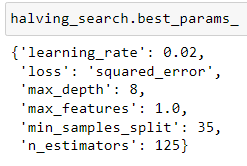
Выбрал эти признаки['total_meters','price','year_of_construction','living_meters','city'], потому что они имели наибольшую важность среди всех остальных

In [ ]:
y = data[(data['kitchen_meters'].notnull())]['kitchen_meters'].copy()
X = data[(data['kitchen_meters'].notnull())].loc[:,['total_meters','price','year_of_construction','living_meters','city']].copy()
label_encoder = LabelEncoder()
for item in ['city']:
    X[item] = label_encoder.fit_transform(X[item])
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = GradientBoostingRegressor(learning_rate = 0.02,
                                  n_estimators = 170,
                                  min_samples_split = 35,
                                  min_samples_leaf = 5,
                                  min_weight_fraction_leaf = 0.0,
                                  min_impurity_decrease = 10.5,
                                  max_leaf_nodes = 170,
                                  criterion = 'friedman_mse',
                                  max_depth =8,
                                  verbose = 1,
                                  loss = 'squared_error',
                                  max_features = 1.0,
                                  random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred) 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print('mae: %.3f \nmse: %.3f \nrmse: %.3f \nr2:%.3f'%(mae,mse,rmse,r2))

In [ ]:
sns.histplot(y_test)
sns.histplot(y_pred);

## AdaBoost

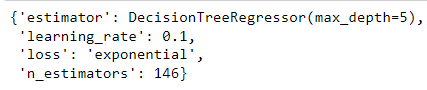

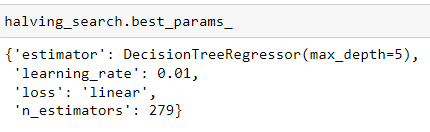

Строю модель по уже подобранным параметрам

In [ ]:
y = data[(data['kitchen_meters'].notnull())]['kitchen_meters'].copy()
X = data[(data['kitchen_meters'].notnull())].loc[:,['total_meters',
                                                    'price',
                                                    'year_of_construction',
                                                    'living_meters',
                                                    'author'
                                                    ]].copy() # 'author','price_per_m2'
label_encoder = LabelEncoder()
for item in ['author']:
    X[item] = label_encoder.fit_transform(X[item])
                                                 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
plt.figure(figsize = (3,3))
sns.boxplot(y_train.values);

In [ ]:
iqr = stats.iqr(y_train) # разница между 3 и 1 квартилями
q1 = np.quantile(y_train, 0.25)
q3 = np.quantile(y_train, 0.75)
lower = q1 - iqr * 1.5
upper = q3 + iqr * 1.5
outliers = y_train[(y_train < lower) | (y_train > upper)]
y_train.drop(outliers.index, inplace = True)

In [ ]:
plt.figure(figsize = (3,3))
sns.boxplot(y_train.values);

In [ ]:
iqr = stats.iqr(y_test) # разница между 3 и 1 квартилями
q1 = np.quantile(y_test, 0.25)
q3 = np.quantile(y_test, 0.75)
lower = q1 - iqr * 1.5
upper = q3 + iqr * 1.5
outliers = y_test[(y_test < lower) | (y_test > upper)]
y_test.drop(outliers.index, inplace = True)

In [ ]:
X_train = X_train.loc[y_train.index]
X_test = X_test.loc[y_test.index]
DTR = DecisionTreeRegressor(max_depth=12,
                            min_samples_split = 14,
                            min_samples_leaf = 5,
                            min_weight_fraction_leaf = 0.0,
                            min_impurity_decrease=0.0)

ABC = AdaBoostRegressor(random_state=42,
                        estimator = DTR, 
                        n_estimators=159, 
                        learning_rate=0.01, 
                       loss='exponential')
ABC.fit(X_train, y_train)
y_pred = ABC.predict(X_test)
mae = mean_absolute_error(y_test, y_pred) 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # показывает дисперсию ошибки
r2 = r2_score(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
print('mae: %.3f \nmse: %.3f \nrmse: %.3f \nr2:%.3f \nmedae:%.3f'%(mae,mse,rmse,r2,medae))

In [ ]:
resid = y_test - y_pred
sm.stats.stattools.durbin_watson(resid)

In [ ]:
# распределение ошибок
plt.figure(figsize= (3,3))
plt.hist(resid,bins = 30);

In [ ]:
# гомоскедастичность остатков
for i in range(0,5):
    plt.figure(figsize= (3,3))
    plt.scatter(X_test.iloc[:,i].values, resid.values, alpha=0.5)
    plt.axhline(y=0, color='g', linestyle='-')
    plt.xlabel(f'{X_test.columns[i]}')
    plt.ylabel('Остатки')
    plt.title(f'График остатков для {X_test.columns[i]}')
plt.show()

In [ ]:
sns.histplot(y_test)
sns.histplot(y_pred);

In [ ]:
scores = cross_val_score(ABC, X_test, y_test, cv=5)
print('CV R^2: {:.3f} +- {:.3f}'.format(np.mean(scores), np.std(scores)))

In [ ]:
ABC.feature_importances_

In [ ]:
# Эти наблюдения содержат аномальные значения в столбце kitchen_meters, возможно, при заполнении пропусков стоит убрать значения
# Здесь я ищу средние значения независимых переменных, в которых kitchen_meters имеет аномальные значения
iqr = stats.iqr(data[(data['kitchen_meters'].notnull())]['kitchen_meters'])
q3 = np.quantile(data[(data['kitchen_meters'].notnull())]['kitchen_meters'], 0.75)
upper = q3 + iqr * 1.5
anomal_data = data[(data['kitchen_meters'].notnull()) & (data['kitchen_meters'] > upper)].sort_values(['price','living_meters']).describe()

In [ ]:
# эти данные нужно выкинуть перед заполнением, так как скорее всего, kitchen_meters будет аномальным у них
data_nan_anomal = data[(data.price > anomal_data.price['25%']) & 
     (data.total_meters > anomal_data.total_meters['25%']) &
     (data.price_per_m2 > anomal_data.price_per_m2['25%']) &
     (data.year_of_construction > anomal_data.year_of_construction['25%']) &
     (data.living_meters > anomal_data.living_meters['25%']) & (data['kitchen_meters'].isna())]

In [ ]:
data_nan_anomal.shape

# Удаляю все наблюдения, которые не удалось заполнить

In [ ]:
data.shape

In [ ]:
data.isna().sum()

In [ ]:
data.drop(data[data.street.isna()].index, inplace = True)
data.drop(data[data.kitchen_meters.isna()].index, inplace = True)

In [ ]:
data.drop(data[data.underground.isna()].index, inplace = True)
data.drop(['residential_complex'] , axis = 1, inplace = True)

In [ ]:
data.shape

In [ ]:
data.isna().sum()

In [ ]:
# import pygsheets
# data_for_dashboard = data[['author', 'city', 'district', 'street', 'underground']].copy()
# # https://pygsheets.readthedocs.io/en/stable/authorization.html(json скачаю, палить его нельзя)
# gc = pygsheets.authorize(service_file='path/to/credentials.json')

# # Открытие таблицы по URL
# sh = gc.open_by_url('spreadsheet_url')

# # Выбор рабочего листа
# wks = sh[0]

# # Создание датафрейма
# df = pd.DataFrame({'A': [1, 2], 'B': [3, 4]})

# # Загрузка данных из датафрейма в Google Таблицы
# wks.set_dataframe(df, 'A1')

In [ ]:
# data_for_dashboard = data[['author', 'city', 'district', 'street', 'underground']].copy()
# data_for_dashboard.to_csv('data_for_dashboard.csv', sep = ';',index= False)

# Создание главного алгоритма по предсказанию цены

In [ ]:
X = data.copy()

label_encoder = LabelEncoder()
for item in X.select_dtypes(['object']): 
    X[item] = label_encoder.fit_transform(X[item])
    
corr_matrix = X.corr(numeric_only =True)
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.35] = 0
plt.figure(figsize=(5,5))
sns.heatmap(corr_matrix,annot=True,linewidths = 0.5, cmap = 'coolwarm');

In [ ]:
plt.figure(figsize = (3,3))
sns.histplot(data=data['price'],bins =50);

### AdaBoostRegressor оказался наилучшим
У DecisionTreeRegressor нет требования к масштабу данных, так как он не использует расстояния между наблюдениями, нет требований по линейности данных, на качество могут повлиять выбросы

In [ ]:
y = data['price'].copy()
X = data.loc[:,['author', 'city', 'floor', 'floors_count', 'rooms_count',
                'total_meters', 'year_of_construction','living_meters', 'kitchen_meters', 
                'district', 'street', 'underground']].copy() 

dict_classes = {}
for item in X.select_dtypes(['object']):
    label_encoder = LabelEncoder()
    label_encoder = copy.copy(label_encoder.fit(X[item]))
    dict_classes[item] = label_encoder
    X[item] = label_encoder.transform(X[item])

# Удаление выбросов в y
iqr = stats.iqr(y) # разница между 3 и 1 квартилями
q3 = np.quantile(y, 0.75)
upper = q3 + iqr * 1.5
outliers = y[(y > upper)]
# потом на реальных данных можо выкидывать те значения Х, которые являются выбросами в тренировочном наборе и выводить алерт,
# что мол вы ввели аномально большие значения. Пороговые значения для вывода алерта нужно будет потом определить как-нибудь
outliers_stats = X.loc[outliers.index].describe()

y.drop(outliers.index, inplace = True)
X = X.loc[y.index]

In [ ]:
outliers_stats

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
plt.figure(figsize = (3,3))
sns.boxplot(y.values);

criterion='absolute_error',
                            max_depth= 9,
                            max_features=1.0,
                            min_samples_split=7,
                            splitter='best',
                            min_weight_fraction_leaf=0.004227138227420037,
                            min_impurity_decrease =0.02
{'criterion': 'poisson',
 'max_depth': 5,
 'max_features': 1.0,
 'min_samples_split': 8,
 'min_weight_fraction_leaf': 0.004227138227420037,
 'splitter': 'best'}

In [ ]:
DTR = DecisionTreeRegressor(random_state=42,
                            splitter='best',
                            max_depth= None)

ABC = AdaBoostRegressor(random_state=42,
                        estimator = DTR, 
                        n_estimators=155, 
                        learning_rate=0.01, 
                       loss='linear')
ABC.fit(X_train, y_train)
y_pred = ABC.predict(X_test)
mae = mean_absolute_error(y_test, y_pred) 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # показывает дисперсию ошибки
r2 = r2_score(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
print('mae: %.3f \nmse: %.3f \nrmse: %.3f \nr2:%.3f \nmedae:%.3f'%(mae,mse,rmse,r2,medae))

In [ ]:
#joblib.dump(ABC,'AdaBoostRegressor.joblib')

### Примерный алгоритм как должен работать в дэшборде 

In [ ]:
input_data = np.array(['GloraX','Sankt-Peterburg',6,19,2,60.1,2025,27.1,14.4,'Vasileostrovskij','Morskoj','Zenit'])
input_data = pd.Series(input_data, index =X.columns)
for key in dict_classes.keys():
    input_data[key] = dict_classes[key].transform(np.array([input_data[key]])).item()
input_data = input_data.values.reshape(1,-1)
np.round(ABC.predict(input_data).item())

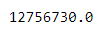

In [ ]:
np.set_printoptions(suppress=True)
ABC.feature_importances_

Попробовал подобрать наилучшие параметры DecisionTreeRegressor

In [ ]:
i = 1
n = X_train.shape[0]
print(n)
while i < 3:
    n //=3
    print(n)
    i+=1
print(f'нужно использовать {n} с factor = 3')

In [ ]:
%time
# default_weight = 1/y_train.shape[0]
# DTR = DecisionTreeRegressor()
# params = {'criterion':['squared_error', 'absolute_error','friedman_mse','poisson'],
#           'splitter': ['best', 'random'],
#           'max_depth':np.logspace(1.1, 1.9, num=5, endpoint=True, base=5, dtype=int).tolist(),
#           'min_samples_split':np.logspace(0.65, 1.5, num=7, endpoint=True, base=5, dtype=int).tolist(),
#           'min_weight_fraction_leaf':[0.0,default_weight*30,default_weight*50],
#           'max_features':[1.0,'sqrt','log2']}

# halving_search = HalvingGridSearchCV(estimator=DTR,
#                            param_grid=params,
#                            cv=5,
#                            aggressive_elimination=True,
#                            min_resources= 'exhaust',#n
#                            factor= 3,
#                            n_jobs = 2)
# halving_search.fit(X_train,y_train)

# y_pred = halving_search.predict(X_test)
mae = mean_absolute_error(y_test, y_pred) 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
# rmsle
print('mae: %.3f \nmse: %.3f \nrmse: %.3f \nr2:%.3f \nmedae:%.3f'%(mae,mse,rmse,r2,medae))

## Нейронная сеть

In [ ]:
y = data['price'].copy()
X = data.loc[:,['author', 'city', 'floor', 'floors_count', 'rooms_count',
                'total_meters', 'year_of_construction','living_meters', 'kitchen_meters', 
                'district', 'street', 'underground']].copy() 
# Кодирование в числа
dict_classes = {}
for item in X.select_dtypes(['object']):
    label_encoder = LabelEncoder()
    label_encoder = copy.copy(label_encoder.fit(X[item]))
    dict_classes[item] = label_encoder
    X[item] = label_encoder.transform(X[item])
# нормализация
# сначала нужно заскейлить тренировочные данные, а затем применить те же параметры скейла к тестовым
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Создаем модель
model = Sequential()

# Добавляем скрытый слой с 10 нейронами и активационной функцией ReLU
model.add(Dense(10, input_dim=12, activation='relu'))

# Добавляем выходной слой с одним нейроном (так как у нас один выход) и без активационной функции
model.add(Dense(1))

# Компилируем модель с функцией потерь MSE и оптимизатором Adam
model.compile(loss='mean_squared_error', optimizer='adam')

# Обучаем модель на наших данных
model.fit(X, y, epochs=100, batch_size=10)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred) 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
# rmsle
print('mae: %.3f \nmse: %.3f \nrmse: %.3f \nr2:%.3f \nmedae:%.3f'%(mae,mse,rmse,r2,medae))

### Gradient Boosting

In [ ]:
y = data['price'].copy()
X = data.loc[:,['author', 'city','floors_count',
                'total_meters', 'year_of_construction','living_meters', 
                'district', 'street', 'underground']].copy()
dict_classes = {}
for item in X.select_dtypes(['object']):
    label_encoder = LabelEncoder()
    label_encoder = copy.copy(label_encoder.fit(X[item]))
    dict_classes[item] = label_encoder
    X[item] = label_encoder.transform(X[item])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Веса по умолачанию у каждого примера обучающего 1/n
default_weight = 1/y_train.shape[0]
sample_weight = np.full_like(y_train, default_weight, dtype = float)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

{'learning_rate': 0.1,
 'loss': 'absolute_error',
 'max_depth': 9,
 'min_samples_split': 2,
 'n_estimators': 146,
 'subsample': 0.9}

In [ ]:

model = GradientBoostingRegressor(learning_rate = 0.09,
                                  loss='squared_error',
                                  n_estimators = 135,
                                  subsample = 1.0,
                                  verbose = 1,
                                  max_features = 1.0,
                                  max_depth = 8,
                                  random_state=42)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred) 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
print('mae: %.3f \nmse: %.3f \nrmse: %.3f \nr2:%.3f \nmedae:%.3f'%(mae,mse,rmse,r2,medae))

In [ ]:
input_data = np.array(['GloraX','Sankt-Peterburg',19,60.1,2025,27.1,'Vasileostrovskij','Morskoj','Zenit'])
input_data = pd.Series(input_data, index =X.columns)
for key in dict_classes.keys():
    input_data[key] = dict_classes[key].transform(np.array([input_data[key]])).item()
input_data = input_data.values.reshape(1,-1)
np.round(model.predict(input_data).item())

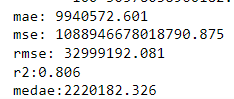

In [ ]:
model.feature_importances_

In [ ]:
resid = y_test - y_pred
plt.figure(figsize= (3,3))
plt.scatter(y_test,resid)
plt.xlabel('y_test')
plt.ylabel('resid');

In [ ]:
big_residuls_range_y_test = y_test[resid > rmse].sort_values()
fig, ax = plt.subplots(figsize =(3,3) )
ax.ticklabel_format(style='plain', axis='x')
ax.ticklabel_format(style='plain', axis='y')
plt.hist(big_residuls_range_y_test,bins = 30)
plt.xticks(rotation = 45);

In [ ]:
i = 1
n = X_train.shape[0]
print(n)
while i < 3:
    n //=3
    print(n)
    i+=1
print(f'нужно использовать {n} с factor = 3')

Напоминание: CatBoost

In [ ]:
%%time
sample_weight[np.where((y_train >big_residuls_range_y_test.min()) 
                       & (y_train <big_residuls_range_y_test.max()), True, False)] = default_weight * 1.15
model = GradientBoostingRegressor(random_state=42)
# model = GradientBoostingRegressor(learning_rate = 0.09,
#                                   n_estimators = 135,
#                                   verbose = 1,
#                                   max_features = 1.0,
#                                   random_state=42)

#model.fit(X_train,y_train,sample_weight = sample_weight)

params = {'loss':['squared_error', 'absolute_error'],
          'max_depth':np.logspace(1.4, 1.9, num=3, endpoint=True, base=5, dtype=int).tolist(),
          'subsample' : [0.7,0.8,0.9],
         'learning_rate': [0.05,0.075,0.1],
         'n_estimators':np.logspace(3, 3.2, num=3, endpoint=True, base=5, dtype=int).tolist(),
         'min_samples_split':np.logspace(0.65, 1.5, num=3, endpoint=True, base=5, dtype=int).tolist()}

halving_search = HalvingGridSearchCV(estimator=model,
                           param_grid=params,
                           cv=5,
                           aggressive_elimination=True,
                           max_resources=5000,
                           min_resources= n,
                           factor= 3,
                           n_jobs = 2)
halving_search.fit(X_train,y_train)

y_pred = halving_search.predict(X_test)
mae = mean_absolute_error(y_test, y_pred) 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
# rmsle
print('mae: %.3f \nmse: %.3f \nrmse: %.3f \nr2:%.3f \nmedae:%.3f'%(mae,mse,rmse,r2,medae))

In [ ]:
halving_search.best_params_

In [ ]:
best_estimator = halving_search.best_estimator_.fit(X_train,y_train,sample_weight = sample_weight)
y_pred = best_estimator.predict(X_test)
mae = mean_absolute_error(y_test, y_pred) 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
# rmsle
print('mae: %.3f \nmse: %.3f \nrmse: %.3f \nr2:%.3f \nmedae:%.3f'%(mae,mse,rmse,r2,medae))

# Заполнение пропусков в street

#### Удаление выбросов в price и price_per_m2

In [ ]:
X = data.loc[~data.street.isna() & (data.underground.notnull()), ['floors_count',
                                                                  'price_per_m2', 
                                                                  'price', 
                                                                  'year_of_construction',
                                                                  'district','underground']]
y = data.loc[~data.street.isna(),'street']

In [ ]:
figure, axes = plt.subplots(nrows = 2, ncols = 1)
sns.boxplot(X.price,ax = axes[0])
axes[0].set_title('price')
sns.boxplot(X.price_per_m2, ax = axes[1])
axes[1].set_title('price_per_m2');

In [ ]:
iqr = stats.iqr(X.price) # разница между 3 и 1 квартилями
#q1 = np.quantile(X.price, 0.25)
q3 = np.quantile(X.price, 0.75)
#lower = q1 - iqr * 1.5
upper = q3 + iqr * 1.2
outliers = X.price[X.price > upper]
X.drop(outliers.index, inplace = True)

In [ ]:
iqr = stats.iqr(X.price_per_m2) # разница между квантилем 3 и 1 квартилями
#q1 = np.percentile(X.price_per_m2, 25)
q3 = np.percentile(X.price_per_m2, 75)
#lower = q1 - iqr * 1.5
upper = q3 + iqr * 1.4
outliers = X.price_per_m2[(X.price_per_m2 > upper)]
X.drop(outliers.index, inplace = True)

In [ ]:
figure, axes = plt.subplots(nrows = 2, ncols = 1)
sns.boxplot(X.price,ax = axes[0])
axes[0].set_title('price')
sns.boxplot(X.price_per_m2, ax = axes[1])
axes[1].set_title('price_per_m2');

In [ ]:
X.shape

In [ ]:
X.isna().sum()

#### Закончив удалять выбросы, приступлю к заполнению

смогу заполнить столько пропусков в street, если оставлю в независимых переменных district и underground, решу оставлять их или нет после того как посмотрю на их важность для классификации

In [ ]:
data.loc[(data.street.isna()) & ((data.district.notnull())) & (data.underground.notnull())].isna().sum()

In [ ]:
y = y[X.index]

Увеличение количества наблюдений малочисленных классов

In [ ]:
classes_less_than_5 = y.value_counts()[y.value_counts() <5].index
sample_strategy = {item: 5 for item in classes_less_than_5}

ROS = RandomOverSampler(sampling_strategy = sample_strategy)
X, y  = ROS.fit_resample(X,y)

Перекодирование категориальных переменных в числовые

In [ ]:
label_encoder = LabelEncoder()
for item in ['district','underground']: 
    X[item] = label_encoder.fit_transform(X[item])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Приведение данных к одному масштабу

In [ ]:
# сначала нужно заскейлить тренировочные данные, а затем применить те же параметры скейла к тестовым
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## AdaBoostClassifier

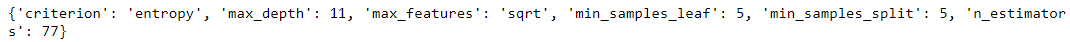

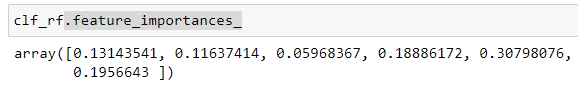

In [ ]:
DTC = DecisionTreeClassifier(criterion='entropy',
                            max_depth= 15,
                            max_features='sqrt',
                            min_samples_leaf=15,
                            min_samples_split=15,
                            random_state=42)
ABC = AdaBoostClassifier(random_state=42,
                            estimator=DTC, 
                            n_estimators=150,
                            learning_rate=0.1, 
                            algorithm='SAMME.R')
ABC.fit(X_train, y_train)
y_pred = ABC.predict(X_test)

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred,zero_division = 'warn')
print(precision.mean())
print(recall.mean())
print(fscore.mean())

In [ ]:
(pd.Series(y_pred) == "Il'menskij proezd").sum()

In [ ]:
x_nan_street = data.loc[data.street.isna() & ((data.district.notnull())) & (data.underground.notnull()), ['floors_count',
                                            'price_per_m2', 
                                            'price', 
                                            'year_of_construction',
                                            'district',
                                            'underground']]

In [ ]:
iqr = stats.iqr(x_nan_street.price) # разница между 3 и 1 квартилями
q3 = np.quantile(x_nan_street.price, 0.75)
upper = q3 + iqr * 0.1
outliers = x_nan_street.price[x_nan_street.price > upper]
x_nan_street.drop(outliers.index, inplace = True)

iqr = stats.iqr(x_nan_street.price_per_m2) # разница между квантилем 3 и 1 квартилями
q3 = np.percentile(x_nan_street.price_per_m2, 75)
upper = q3 + iqr * 1.5
outliers = x_nan_street.price_per_m2[(x_nan_street.price_per_m2 > upper)]
x_nan_street.drop(outliers.index, inplace = True)

In [ ]:
figure, axes = plt.subplots(nrows = 2, ncols = 1)
sns.boxplot(x_nan_street.price.values,ax = axes[0])
axes[0].set_title('price')
sns.boxplot(x_nan_street.price_per_m2.values, ax = axes[1])
axes[1].set_title('price_per_m2');

In [ ]:
x_nan_street.shape

In [ ]:
label_encoder = LabelEncoder()
for item in ['district','underground']: 
    x_nan_street[item] = label_encoder.fit_transform(x_nan_street[item])
    
# сначала нужно заскейлить тренировочные данные, а затем применить те же параметры скейла к тестовым
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
x_nan_street = scaler.transform(x_nan_street)

street_nan = data.loc[(data.street.isna()) & ((data.district.notnull())) & (data.underground.notnull()),'street']
street_nan = ABC.predict(x_nan_street)

Хуйня получилась в общем и целом

In [ ]:
pd.Series(street_nan).value_counts()

In [ ]:
DTC = DecisionTreeClassifier(criterion='entropy',
                            max_depth= 15,
                            max_features='sqrt',
                            min_samples_leaf=15,
                            min_samples_split=15,
                            random_state=42)
EEC = EasyEnsembleClassifier(random_state=42,
                            estimator=DTC, 
                            n_estimators=95,
                            verbose = 1)
EEC.fit(X_train, y_train)
y_pred = EEC.predict(X_test)
type(classification_report(y_test, y_pred))
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred,zero_division = 'warn')
print(precision.mean())
print(recall.mean())
print(fscore.mean())

## Заполнение пропусков в underground

In [ ]:
X = data.loc[(~data.underground.isna()) & (~data.district.isna()), ['author','floors_count',
       'price_per_m2', 'price', 'year_of_construction','district','street']]

y = data.loc[~data.underground.isna(),'underground']

In [ ]:
classes_less_than_5 = y.value_counts()[y.value_counts() <5].index
sample_strategy = {item: 5 for item in classes_less_than_5}

ROS = RandomOverSampler(sampling_strategy = sample_strategy)
X, y  = ROS.fit_resample(X,y)

label_encoder = LabelEncoder()
for item in ['author','district','street']: 
    X[item] = label_encoder.fit_transform(X[item])
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Возможно, стоит использовать RobustScaler, так он более устойчив к выбросам
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Возможно, стоит еще от выбросов почистить

## RandomForestClassifier

In [ ]:
clf_rf = RandomForestClassifier(criterion='entropy',
                                max_depth= 15,
                                max_features='sqrt',
                                min_samples_leaf=5,
                                min_samples_split=5,
                                n_estimators=175,
                                random_state=42,
                                class_weight = 'balanced')

clf_rf.fit(X_train,y_train)
y_pred = clf_rf.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred,zero_division = 1)
print(precision.mean())
print(recall.mean())
print(fscore.mean())

## AdaBoostClassifier( DecisionTreeClassifier )

In [ ]:
DTC = DecisionTreeClassifier(criterion='entropy',
                            max_depth= 25,
                            max_features='sqrt',
                            min_samples_leaf=10,
                            min_samples_split=10,
                            random_state=42,
                            class_weight = 'balanced')
ABC = AdaBoostClassifier(random_state=42,
                            estimator=DTC, 
                            n_estimators=150,
                            learning_rate=0.1, 
                            algorithm='SAMME.R')
ABC.fit(X_train, y_train)
y_pred = ABC.predict(X_test)

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred,zero_division = 'warn')
print(precision.mean())
print(recall.mean())
print(fscore.mean())

In [ ]:
ABC.feature_importances_

## OnevsRestClassifier(SVC)
OnevsOneClassifier очень не подходит для ситуаций, когда классов очень много

In [ ]:
X = data.loc[(~data.underground.isna()) & (~data.district.isna()), ['author','floors_count',
       'price_per_m2', 'price', 'year_of_construction','district','street']]

y = data.loc[~data.underground.isna(),'underground']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
iqr = stats.iqr(X_train.price) # разница между 3 и 1 квартилями
q3 = np.quantile(X_train.price, 0.75)
upper = q3 + iqr * 1.4
outliers = X_train.price[X_train.price > upper]
X_train.drop(outliers.index, inplace = True)

iqr = stats.iqr(X_train.price_per_m2) # разница между квантилем 3 и 1 квартилями
q3 = np.percentile(X_train.price_per_m2, 75)
upper = q3 + iqr * 1.5
outliers = X_train.price_per_m2[(X_train.price_per_m2 > upper)]
X_train.drop(outliers.index, inplace = True)
y_train = y_train[X_train.index]

In [ ]:
classes_less_than_5 = y_train.value_counts()[y_train.value_counts() <5].index
sample_strategy = {item: 5 for item in classes_less_than_5}
ROS = RandomOverSampler(sampling_strategy = sample_strategy)
X_train, y_train  = ROS.fit_resample(X_train,y_train)

label_encoder = LabelEncoder()
for item in ['author','district','street']: 
    X_train[item] = label_encoder.fit_transform(X_train[item])
    X_test[item] = label_encoder.fit_transform(X_test[item])
    
classes_less_than_15 = y_train.value_counts()[y_train.value_counts() <15].index
sample_strategy = {item: 15 for item in classes_less_than_15}

# y_train = y_train.drop(y_train[y_train.isin(classes_less_than_5.values)].index, axis = 0)
# X_train = X_train.loc[y_train.index]

sm = SMOTE(random_state=42,k_neighbors =4, sampling_strategy = sample_strategy)
X_train, y_train = sm.fit_resample(X_train, y_train) 

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train.shape

In [ ]:
from sklearn.svm import SVC
SVC = SVC(random_state=42, 
          probability = True, 
          kernel = 'rbf',
          cache_size=300,
          class_weight = 'balanced')
OVR = OneVsOneClassifier(SVC)
OVR.fit(X_train, y_train)
y_pred = OVR.predict(X_test)

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred,zero_division = 'warn')
print(precision.mean())
print(recall.mean())
print(fscore.mean())

без сэплирования (RandomOverSampler)
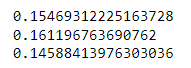

с сэплированием(RandomOverSampler) и class_weight = 'balanced'
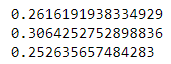

In [ ]:
DTC = DecisionTreeClassifier(criterion='entropy',
                            max_depth= 25,
                            max_features='sqrt',
                            min_samples_leaf=10,
                            min_samples_split=10,
                            random_state=42,
                            class_weight = 'balanced')
ABC = AdaBoostClassifier(random_state=42,
                            estimator=DTC, 
                            n_estimators=150,
                            learning_rate=0.1, 
                            algorithm='SAMME.R')
ABC.fit(X_train, y_train)
y_pred = ABC.predict(X_test)

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred,zero_division = 'warn')
print(precision.mean())
print(recall.mean())
print(fscore.mean())

In [ ]:
clf_rf.feature_importances_

In [ ]:
# x_nan_district = data.loc[data.district.isna(), ['author','author_type','floor', 'floors_count', 'rooms_count',
#        'total_meters', 'price_per_m2', 'price', 'year_of_construction','living_meters', 'residential_complex','street']]